# AML

In [1]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

* The first time that you run the next cell will return an error: *AttributeError: module 'scipy.fft' has no attribute 'next_fast_len'*.
* This is a known error in *scipy 0.19.1* and has been fixed. It's due to some libraries being loaded in the wrong order. 
* If you run the cell again it will run without errors (lost a ton of time figuring this out)
* I choose to leave this as is because *scipy 0.19* is the last version that implements the *scipy.misc.imread* which is used when reading the images. 
* (Also lost a ton of time with this) I tried implementing the same functionality with *openCV* but due to other dependencies the newest version of *openCV* that's compatible with the code loads the images with a blue tone

In [3]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

from parameters import *
from lib.utils import *
from lib.attacks import *
from lib.keras_utils import *
from lib.RandomTransform import *
from lib.OptCarlini import *
from lib.OptTransform import *

from lib.tf_utils import *

### Check versions
* Checks loaded versions
* Checks that tensorflow recognizes the GPUs available

In [4]:
import tensorflow as tf
print('tensorflow version:', tf.__version__)

import scipy
print('scipy version', scipy.__version__)

import numpy as np
print('numpy version:',np.__version__)

from tensorflow.python.platform import build_info as tf_build_info
print('cuda version:', tf_build_info.cuda_version_number)
print('cudnn version:', tf_build_info.cudnn_version_number)

# Check GPUs
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU'))) 
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

tensorflow version: 1.15.0
scipy version 0.19.1
numpy version: 1.16.0
cuda version: 10.0
cudnn version: 7.6
Num GPUs Available: 2
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0



### Train Model
* Here we train the NN model on GTRB
* After solving GPU errors this no longer takes multiple hours, but still takes 15min+
* This will save the weights of the trained model to the *filepath* specified so instead of running the model each time we can load the weights 

In [5]:
# Set training metadata
LOAD_WEIGHTS = False
LOAD_WEIGHTS_PATH = './weights.24-0.20.hdf5'
TRAIN_FILE_NAME = 'train.p'

# Build model. model is a compiled Keras model with last layer being logits.
model = build_mltscl()
if LOAD_WEIGHTS:
    model.load_weights(LOAD_WEIGHTS_PATH)

# Load dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset_GTSRB(
    n_channel=N_CHANNEL, train_file_name=TRAIN_FILE_NAME)

# Convert to one-hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test = keras.utils.to_categorical(y_test, NUM_LABELS)
y_val = keras.utils.to_categorical(y_val, NUM_LABELS)

# Path to save weights
filepath = './og_model_weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5'

# Callback function to save weights every epoch
modelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', period=1)
# Callback function for early stopping
# earlyStop = keras.callbacks.EarlyStopping(
#    monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto')

model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCH, verbose=1,
          callbacks=[modelCheckpoint], validation_data=(
              x_val, y_val),
          shuffle=True, initial_epoch=0)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Train on 34799 samples, validate on 4410 samples
Epoch 1/100




34799/34799 [==============================] - 10s 275us/step - loss: 2.1851 - acc: 0.4339 - val_loss: 1.5873 - val_acc: 0.6188
Epoch 2/100
34799/34799 [==============================] - 7s 197us/step - loss: 0.8276 - acc: 0.7787 - val_loss: 0.9755 - val_acc: 0.7608
Epoch 3/100
34799/34799 [==============================] - 7s 198us/step - loss: 0.4898 - acc: 0.8820 - val_loss: 0.8245 - val_acc: 0.7982
Epoch 4/100
34799/34799 [==============================] - 7s 199us/step - loss: 0.3452 - acc: 0.9273 - val_loss: 0.7409 - val_acc: 0.8277
Epoch 5/100
34799/34799 [==============================] - 7s 198us/step - l

### Check error rate of model

In [77]:
x = K.placeholder(shape=(None, HEIGHT, WIDTH, N_CHANNEL))
error_rate = tf_test_error_rate(model, x, x_test, y_test)
print(f'error_rate: {error_rate[-1]}%')

error_rate: 3.151227236737924%


### Load Model
* Once you've trained your model at least once, you can load it instead

In [98]:
# Build and load trained model
#model = built_mltscl()
model = build_mltscl()

model.load_weights(WEIGTHS_PATH)

# Load dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset_GTSRB(
    n_channel=N_CHANNEL)

print('len(x_train)', len(x_train))
print('type(x_train)', type(x_train))
print('x_train.shape', x_train.shape)
print()
print(f'x_val is {(len(x_val)/len(x_train)) * 100}% of x_train data')
print(f'x_test is {(len(x_test)/len(x_train)) * 100}% of x_train data')
print()

print('Before one-hot encoding:')
print('type(y_train)',type(y_train))
print('len(y_train)',len(y_train))
print('y_train[0]',y_train[0])
print('y_train.shape', y_train.shape)
print()

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test = keras.utils.to_categorical(y_test, NUM_LABELS)
y_val = keras.utils.to_categorical(y_val, NUM_LABELS)

print('After categorical:')
print('len(y_train)', len(y_train))
print('type(y_train)', type(y_train))
print('y_train.shape', y_train.shape)

# Read sign names
signnames = read_csv("./input_data/signnames.csv").values[:, 1]

len(x_train) 34799
type(x_train) <class 'numpy.ndarray'>
x_train.shape (34799, 32, 32, 3)

x_val is 12.672777953389467% of x_train data
x_test is 36.29414638351677% of x_train data

Before one-hot encoding:
type(y_train) <class 'numpy.ndarray'>
len(y_train) 34799
y_train[0] 41
y_train.shape (34799,)

After categorical:
len(y_train) 34799
type(y_train) <class 'numpy.ndarray'>
y_train.shape (34799, 43)


In [99]:
# Read sign names
print('signnames', signnames)

signnames ['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vechiles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vechiles' 'Vechiles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road'
 'Slippery road' 'Road narrows on the right' 'Road work' 'Traffic signals'
 'Pedestrians' 'Children crossing' 'Bicycles crossing'
 'Beware of ice/snow' 'Wild animals crossing'
 'End of all speed and passing limits' 'Turn right ahead'
 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' 'Keep right' 'Keep left' 'Roundabout mandatory'
 'End of no passing' 'End of no passing by vechiles over 3.5 metric tons']


In [100]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 32, 32, 32)   2432        input_10[0][0]                   
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 32, 32, 32)   0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_46 (MaxPooling2D) (None, 16, 16, 32)   0           dropout_37[0][0]                 
__________________________________________________________________________________________________
conv2d_29 

### Generate Attacks

In [101]:
SAMPLE_IMG_DIR = './images/Original_Traffic_Sign_samples/'
SAMPLE_LABEL = './images/Original_Traffic_Sign_samples/labels.txt'

In [102]:
# Load sample images, labels and masks
x_smp, x_smp_full, y_smp, masks, masks_full = load_samples(SAMPLE_IMG_DIR, SAMPLE_LABEL)

/home/dferna3/.conda/envs/myenv3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or
/home/dferna3/.conda/envs/myenv3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/dferna3/.conda/envs/myenv3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


## Fast Gradient
* Here I generate *size* adversarial examples with the **Fast Gradient** attack and measure the accuracy of the model

In [103]:
# Set target class to attack
tg = 10
print("Target class: " + signnames[tg])
# Set number of samples
size = 100

y_target = np.zeros((len(x_test))) + tg
y_target = keras.utils.to_categorical(y_target, NUM_LABELS)

# Filter samples (originally misclassified, originally classified as target)
x_fil, y_fil, del_id = filter_samples(model, x_smp, y_smp, y_target=y_target)
x_fil_full = np.delete(x_smp_full, del_id, axis=0)
masks_fil = np.delete(masks, del_id, axis=0)
masks_fil_full = np.delete(masks_full, del_id, axis=0)

# Set samples to attack (choose some samples by random)
ind = np.random.choice(range(len(y_fil)), size=size)
x_ben = np.copy(x_fil[ind])
x_ben_full = np.copy(x_fil_full[ind])
y_ben = np.copy(y_fil[ind])
y_tg = np.copy(y_target[ind])
masks_ben = np.copy(masks_fil[ind])
masks_ben_full = np.copy(masks_fil_full[ind])

Target class: No passing for vechiles over 3.5 metric tons


In [104]:
print('len(y_tg)',len(y_tg))
print('len(x_ben)',len(x_ben))
print('len(x_ben_full)',len(x_ben_full))
print('len(masks_ben)',len(masks_ben))

len(y_tg) 100
len(x_ben) 100
len(x_ben_full) 100
len(masks_ben) 100


In [105]:
# Specify list of magnitudes
mag_list = np.linspace(1.0, 2.0, 6)
# Generate fast_gradient examples
x_fg = fg(model, x_ben, y_tg, mag_list, target=True, mask=masks_ben)

/home/dferna3/advml-traffic-sign/lib/attacks.py:51: RuntimeWarning: invalid value encountered in true_divide
  grad /= np.linalg.norm(grad)


In [106]:
print('type(x_fg)', type(x_fg))
print('len(x_fg)', len(x_fg))
print('type(x_fg[5]',type(x_fg[5]))
print('len(x_fg[5])',len(x_fg[5]))

type(x_fg) <class 'numpy.ndarray'>
len(x_fg) 6
type(x_fg[5] <class 'numpy.ndarray'>
len(x_fg[5]) 100


Here we show 3 images generated by the **Fast Gradient** attack

Original class: Speed limit (30km/h)


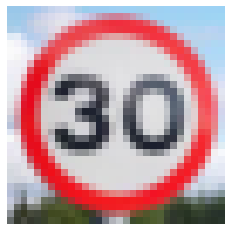

Adversarial class: Speed limit (30km/h)


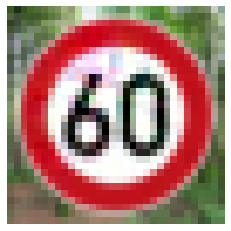

********************************************
Original class: Speed limit (30km/h)


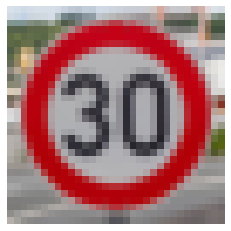

Adversarial class: Speed limit (30km/h)


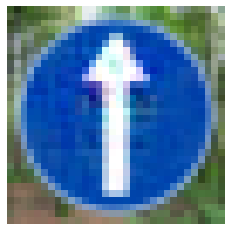

********************************************
Original class: Speed limit (30km/h)


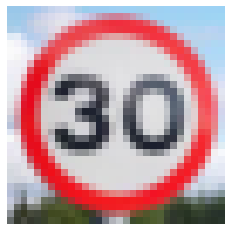

Adversarial class: Speed limit (30km/h)


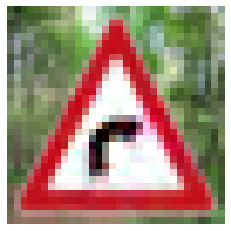

********************************************


In [127]:
for i in range(3):
    im = x_ben[i]
    print("Original class: " + signnames[predict(model, im)])
    plt.imshow(im)
    plt.axis('off')
    plt.show()

    im = x_fg[5, i]
    print("Adversarial class: " + signnames[predict(model, im)])
    plt.imshow(im)
    plt.axis('off')
    plt.show()
    print('********************************************')

In [111]:
#md_imgs = miss-detected images
#md_label = miss-detected labels
md_imgs = np.zeros((size, 32, 32, 3))
md_label = np.zeros((size))
incorrect = 0
for i in range(size):
    im = x_ben[i]
    #print(x_ben[i].shape)
    og_pred = predict(model, im)
    og_class = signnames[og_pred]
    
    im_fg = x_fg[5, i]
    #print('og_class:', og_class)
    adv_class = signnames[predict(model, im_fg)]
    
    #print('adv_class', adv_class)
    if og_class != adv_class:
        md_label[i] = og_pred
        md_imgs[i] = im_fg
        
        incorrect += 1
    
#print('incorrect', incorrect)
#print('len(md_imgs)',len(md_imgs))
#print('md_imgs.shape', md_imgs.shape)
#print('len(md_label)',len(md_label))
#print('md_label.shape', md_label.shape)
print('Accuracy of original model:', (size-incorrect)/size)

incorrect 78
len(md_imgs) 100
md_imgs.shape (100, 32, 32, 3)
len(md_label) 100
md_label.shape (100,)
accuracy: 0.22


### Model based of Fast Gradient miss-detection
* Using the adversarial examples that the **og_model** missclassified we train the model to make it more robust


In [113]:
# Use same distribution for validation and test data
# (13% validation data, 36% = test data)
val_idx = int(incorrect * 0.13)-1
test_idx = int(incorrect * 0.35)-1 + val_idx
#print('train_idx', train_idx)
#print('val_idx', val_idx)
#print('test_idx', test_idx)
x_adv_val = md_imgs[:val_idx]
y_adv_val = md_label[:val_idx]
print('x_adv_val.shape',x_adv_val.shape)
print('y_adv_val.shape',y_adv_val.shape)

x_adv_test = md_imgs[val_idx:test_idx]
y_adv_test = md_label[val_idx:test_idx]
print('x_adv_test.shape',x_adv_test.shape)
print('y_adv_test.shape',y_adv_test.shape)

x_adv_train = md_imgs[test_idx:]
y_adv_train = md_label[test_idx:]
print('x_adv_train.shape',x_adv_train.shape)
print('y_adv_train.shape',y_adv_train.shape)

#print('len(x_adv_val)', len(x_adv_val))
#print('type(x_adv_val)', type(x_adv_val))
#print('type(x_adv_val[0])', type(x_adv_val[0]))
#print('len(y_adv_test)', len(y_adv_test))
#md_dict = {'labels': corr_label, 'features': md_imgs}
#print(md_dict)

x_adv_val.shape (9, 32, 32, 3)
y_adv_val.shape (9,)
x_adv_test.shape (26, 32, 32, 3)
y_adv_test.shape (26,)
x_adv_train.shape (65, 32, 32, 3)
y_adv_train.shape (65,)


In [114]:
# Convert labels to one-hot encoding
y_adv_train = keras.utils.to_categorical(y_adv_train, NUM_LABELS)
y_adv_test = keras.utils.to_categorical(y_adv_test, NUM_LABELS)
y_adv_val = keras.utils.to_categorical(y_adv_val, NUM_LABELS)

In [115]:
print('type(y_adv_train)', type(y_adv_train))
print('len(y_adv_train)', len(y_adv_train))
print('y_adv_train.shape', y_adv_train.shape)
print()
print('len(y_adv_val)', len(y_adv_val))
print('y_adv_val.shape', y_adv_val.shape)
print()
print('len(y_adv_test)', len(y_adv_test))
print('y_adv_test.shape', y_adv_test.shape)

type(y_adv_train) <class 'numpy.ndarray'>
len(y_adv_train) 65
y_adv_train.shape (65, 43)

len(y_adv_val) 9
y_adv_val.shape (9, 43)

len(y_adv_test) 26
y_adv_test.shape (26, 43)


#### **fg_model** training (model based on **Fast Gradient** miss-detection

In [116]:
fg_model = model

# Path to save weights
filepath = './fg_model_weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5'

# Callback function to save weights every epoch
modelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    period=1)

fg_model.fit(x_adv_train,
             y_adv_train,
             batch_size=BATCH_SIZE,
             epochs=NUM_EPOCH,
             verbose=1,
             callbacks=[modelCheckpoint],
             validation_data=(x_adv_val, y_adv_val),
             shuffle=True,
             initial_epoch=0)

Train on 65 samples, validate on 9 samples
Epoch 1/100
65/65 [==============================] - 1s 16ms/step - loss: 17.7800 - acc: 0.0769 - val_loss: 4.8825 - val_acc: 0.1111
Epoch 2/100
65/65 [==============================] - 0s 293us/step - loss: 12.0185 - acc: 0.0615 - val_loss: 4.5392 - val_acc: 0.1111
Epoch 3/100
65/65 [==============================] - 0s 289us/step - loss: 10.3277 - acc: 0.0615 - val_loss: 4.2748 - val_acc: 0.1111
Epoch 4/100
65/65 [==============================] - 0s 386us/step - loss: 9.8460 - acc: 0.0615 - val_loss: 4.0833 - val_acc: 0.1111
Epoch 5/100
65/65 [==============================] - 0s 536us/step - loss: 9.3522 - acc: 0.0615 - val_loss: 3.9555 - val_acc: 0.1111
Epoch 6/100
65/65 [==============================] - 0s 287us/step - loss: 8.2210 - acc: 0.0462 - val_loss: 3.8708 - val_acc: 0.1111
Epoch 7/100
65/65 [==============================] - 0s 380us/step - loss: 7.1594 - acc: 0.0462 - val_loss: 3.8020 - val_acc: 0.0000e+00
Epoch 8/100
65/65 [=

Regenerate *size* adversarial examples with the **Fast Gradient** attack and measure of accuracy of the model

In [122]:
# Set target class to attack
tg = 10
#print("Target class: " + signnames[tg])
# Set number of samples
size = 100

y_target = np.zeros((len(x_test))) + tg
y_target = keras.utils.to_categorical(y_target, NUM_LABELS)

# Filter samples (originally misclassified, originally classified as target)
x_fil, y_fil, del_id = filter_samples(model, x_smp, y_smp, y_target=y_target)
x_fil_full = np.delete(x_smp_full, del_id, axis=0)
masks_fil = np.delete(masks, del_id, axis=0)
masks_fil_full = np.delete(masks_full, del_id, axis=0)

# Set samples to attack (choose some samples by random)
ind = np.random.choice(range(len(y_fil)), size=size)
x_ben = np.copy(x_fil[ind])
x_ben_full = np.copy(x_fil_full[ind])
y_ben = np.copy(y_fil[ind])
y_tg = np.copy(y_target[ind])
masks_ben = np.copy(masks_fil[ind])
masks_ben_full = np.copy(masks_fil_full[ind])

Target class: No passing for vechiles over 3.5 metric tons


We can see that the **fg_model** is no longer subject to adversarial samples generated with the **Fast gradient attack**

In [123]:
md_imgs = np.zeros((size, 32, 32, 3))
md_label = np.zeros((size))
incorrect = 0
for i in range(size):
    im = x_ben[i]
    #print(x_ben[i].shape)
    og_pred = predict(fg_model, im)
    og_class = signnames[og_pred]
    
    im_fg = x_fg[5, i]
    #print('og_class:', og_class)
    adv_class = signnames[predict(fg_model, im_fg)]
    
    #print('adv_class', adv_class)
    if og_class != adv_class:
        md_label[i] = og_pred
        md_imgs[i] = im_fg
        
        incorrect += 1
    
print('incorrect', incorrect)
print('len(md_imgs)',len(md_imgs))
print('md_imgs.shape', md_imgs.shape)
print('len(md_label)',len(md_label))
print('md_label.shape', md_label.shape)
print('Accuracy of original model:', (size-incorrect)/size)

incorrect 0
len(md_imgs) 100
md_imgs.shape (100, 32, 32, 3)
len(md_label) 100
md_label.shape (100,)
Accuracy of original model: 1.0


#### Error Rate

In [124]:
x = K.placeholder(shape=(None, HEIGHT, WIDTH, N_CHANNEL))
error_rate = tf_test_error_rate(fg_model, x, x_test, y_test)
print(f'error_rate: {error_rate[-1]}%')

error_rate: 94.29928741092637%


## Iterative Attack
* Here I generate *size* adversarial examples with the **Iterative Attack** attack and measure the accuracy of the model

In [149]:
# Build and load trained model
#model = built_mltscl()
model = build_mltscl()

model.load_weights(WEIGTHS_PATH)

# Load dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset_GTSRB(
    n_channel=N_CHANNEL)

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test = keras.utils.to_categorical(y_test, NUM_LABELS)
y_val = keras.utils.to_categorical(y_val, NUM_LABELS)

# Read sign names
signnames = read_csv("./input_data/signnames.csv").values[:, 1]

In [150]:
# Load sample images, labels and masks
x_smp, x_smp_full, y_smp, masks, masks_full = load_samples(SAMPLE_IMG_DIR, SAMPLE_LABEL)

/home/dferna3/.conda/envs/myenv3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or
/home/dferna3/.conda/envs/myenv3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/dferna3/.conda/envs/myenv3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [151]:
# Set target class to attack
tg = 10
#print("Target class: " + signnames[tg])
# Set number of samples
size = 100

y_target = np.zeros((len(x_test))) + tg
y_target = keras.utils.to_categorical(y_target, NUM_LABELS)

# Filter samples (originally misclassified, originally classified as target)
x_fil, y_fil, del_id = filter_samples(model, x_smp, y_smp, y_target=y_target)
x_fil_full = np.delete(x_smp_full, del_id, axis=0)
masks_fil = np.delete(masks, del_id, axis=0)
masks_fil_full = np.delete(masks_full, del_id, axis=0)

# Set samples to attack (choose some samples by random)
ind = np.random.choice(range(len(y_fil)), size=size)
x_ben = np.copy(x_fil[ind])
x_ben_full = np.copy(x_fil_full[ind])
y_ben = np.copy(y_fil[ind])
y_tg = np.copy(y_target[ind])
masks_ben = np.copy(masks_fil[ind])
masks_ben_full = np.copy(masks_fil_full[ind])

In [152]:
x_it = iterative(model, x_ben, y_tg, n_step=32, step_size=0.05, target=True, mask=masks_ben)

/home/dferna3/advml-traffic-sign/lib/attacks.py:122: RuntimeWarning: invalid value encountered in true_divide
  grad /= np.linalg.norm(grad)


Here I show *n* of the generated adversarial examples with the **Iterative Attack**

Original class: Speed limit (50km/h)


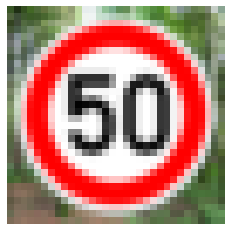

Adversarial class: Speed limit (70km/h)


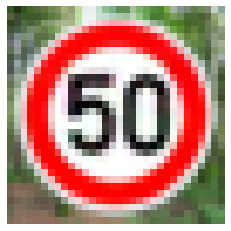

****************************************************
Original class: Keep left


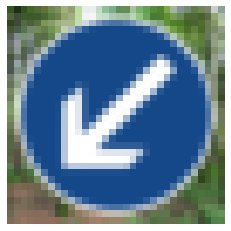

Adversarial class: Roundabout mandatory


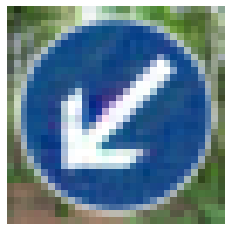

****************************************************
Original class: Dangerous curve to the right


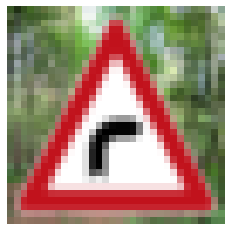

Adversarial class: Bicycles crossing


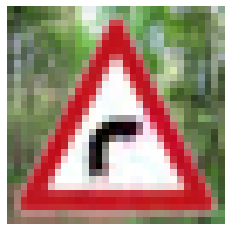

****************************************************


In [153]:
n = 3

for i in range(n):
    im = x_ben[i]
    print("Original class: " + signnames[predict(model, im)])
    plt.imshow(im)
    plt.axis('off')
    plt.show()

    im = x_it[i]
    print("Adversarial class: " + signnames[predict(model, im)])
    plt.imshow(im)
    plt.axis('off')
    plt.show()
    print('****************************************************')

### Model based of Iterative attack miss-detection
* Using the adversarial examples that the **og_model** missclassified we train the model to make it more robust

In [154]:
#md_imgs = miss-detected images
#md_label = miss-detected labels
md_imgs = np.zeros((size, 32, 32, 3))
md_label = np.zeros((size))
incorrect = 0
for i in range(size):
    im = x_ben[i]
    #print(x_ben[i].shape)
    og_pred = predict(model, im)
    og_class = signnames[og_pred]
    
    im_fg = x_it[i]
    #print('og_class:', og_class)
    adv_class = signnames[predict(model, im_fg)]
    
    #print('adv_class', adv_class)
    if og_class != adv_class:
        md_label[i] = og_pred
        md_imgs[i] = im_fg
        
        incorrect += 1
    
#print('incorrect', incorrect)
#print('len(md_imgs)',len(md_imgs))
#print('md_imgs.shape', md_imgs.shape)
#print('len(md_label)',len(md_label))
#print('md_label.shape', md_label.shape)
print('Accuracy of fg_model:', (size-incorrect)/size)

Accuracy of original model: 0.24


In [155]:
# Use same distribution for validation and test data
# (13% validation data, 36% = test data)
val_idx = int(incorrect * 0.13)-1
test_idx = int(incorrect * 0.35)-1 + val_idx
#print('train_idx', train_idx)
#print('val_idx', val_idx)
#print('test_idx', test_idx)
x_adv_val = md_imgs[:val_idx]
y_adv_val = md_label[:val_idx]
print('x_adv_val.shape',x_adv_val.shape)
print('y_adv_val.shape',y_adv_val.shape)

x_adv_test = md_imgs[val_idx:test_idx]
y_adv_test = md_label[val_idx:test_idx]
print('x_adv_test.shape',x_adv_test.shape)
print('y_adv_test.shape',y_adv_test.shape)

x_adv_train = md_imgs[test_idx:]
y_adv_train = md_label[test_idx:]
print('x_adv_train.shape',x_adv_train.shape)
print('y_adv_train.shape',y_adv_train.shape)

#print('len(x_adv_val)', len(x_adv_val))
#print('type(x_adv_val)', type(x_adv_val))
#print('type(x_adv_val[0])', type(x_adv_val[0]))
#print('len(y_adv_test)', len(y_adv_test))
#md_dict = {'labels': corr_label, 'features': md_imgs}
#print(md_dict)

x_adv_val.shape (8, 32, 32, 3)
y_adv_val.shape (8,)
x_adv_test.shape (25, 32, 32, 3)
y_adv_test.shape (25,)
x_adv_train.shape (67, 32, 32, 3)
y_adv_train.shape (67,)


In [156]:
# Convert labels to one-hot encoding
y_adv_train = keras.utils.to_categorical(y_adv_train, NUM_LABELS)
y_adv_test = keras.utils.to_categorical(y_adv_test, NUM_LABELS)
y_adv_val = keras.utils.to_categorical(y_adv_val, NUM_LABELS)

#### **it_model** training (model based on **Iterative attack** miss-detection

In [158]:
it_model = model

# Path to save weights
filepath = './it_model_weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5'

# Callback function to save weights every epoch
modelCheckpoint = keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    period=1)

it_model.fit(x_adv_train,
             y_adv_train,
             batch_size=BATCH_SIZE,
             epochs=NUM_EPOCH,
             verbose=1,
             callbacks=[modelCheckpoint],
             validation_data=(x_adv_val, y_adv_val),
             shuffle=True,
             initial_epoch=0)

Train on 67 samples, validate on 8 samples
Epoch 1/100
The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.
67/67 [==============================] - 0s 330us/step - loss: 3.4443 - acc: 0.1343 - val_loss: 3.3004 - val_acc: 0.0000e+00


OSError: Unable to create file (unable to open file: name = './fg_model_weights/weights.01-3.30.hdf5', errno = 122, error message = 'Disk quota exceeded', flags = 13, o_flags = 242)

Regenerate *size* adversarial examples with the **Iterative Attack** and measure of accuracy of the model

In [ ]:
# Set target class to attack
tg = 10
#print("Target class: " + signnames[tg])
# Set number of samples
size = 100

y_target = np.zeros((len(x_test))) + tg
y_target = keras.utils.to_categorical(y_target, NUM_LABELS)

# Filter samples (originally misclassified, originally classified as target)
x_fil, y_fil, del_id = filter_samples(model, x_smp, y_smp, y_target=y_target)
x_fil_full = np.delete(x_smp_full, del_id, axis=0)
masks_fil = np.delete(masks, del_id, axis=0)
masks_fil_full = np.delete(masks_full, del_id, axis=0)

# Set samples to attack (choose some samples by random)
ind = np.random.choice(range(len(y_fil)), size=size)
x_ben = np.copy(x_fil[ind])
x_ben_full = np.copy(x_fil_full[ind])
y_ben = np.copy(y_fil[ind])
y_tg = np.copy(y_target[ind])
masks_ben = np.copy(masks_fil[ind])
masks_ben_full = np.copy(masks_fil_full[ind])

We can see that the **iter_model** is no longer subject to adversarial samples generated with the **Iterative Attack**

In [154]:
#md_imgs = miss-detected images
#md_label = miss-detected labels
md_imgs = np.zeros((size, 32, 32, 3))
md_label = np.zeros((size))
incorrect = 0
for i in range(size):
    im = x_ben[i]
    #print(x_ben[i].shape)
    og_pred = predict(it_model, im)
    og_class = signnames[og_pred]
    
    im_fg = x_it[i]
    #print('og_class:', og_class)
    adv_class = signnames[predict(it_model, im_fg)]
    
    #print('adv_class', adv_class)
    if og_class != adv_class:
        md_label[i] = og_pred
        md_imgs[i] = im_fg
        
        incorrect += 1
    
#print('incorrect', incorrect)
#print('len(md_imgs)',len(md_imgs))
#print('md_imgs.shape', md_imgs.shape)
#print('len(md_label)',len(md_label))
#print('md_label.shape', md_label.shape)
print('Accuracy of iter_model:', (size-incorrect)/size)

Accuracy of original model: 0.24


## Optimize Attack
* Here I generate *size* adversarial examples with the **Optimize Attack** and measure the accuracy of the model

In [142]:
# Build and load trained model
#model = built_mltscl()
model = build_mltscl()

model.load_weights(WEIGTHS_PATH)

# Load dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_dataset_GTSRB(
    n_channel=N_CHANNEL)

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test = keras.utils.to_categorical(y_test, NUM_LABELS)
y_val = keras.utils.to_categorical(y_val, NUM_LABELS)

# Read sign names
signnames = read_csv("./input_data/signnames.csv").values[:, 1]

In [143]:
# Load sample images, labels and masks
x_smp, x_smp_full, y_smp, masks, masks_full = load_samples(SAMPLE_IMG_DIR, SAMPLE_LABEL)

/home/dferna3/.conda/envs/myenv3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or
/home/dferna3/.conda/envs/myenv3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/dferna3/.conda/envs/myenv3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [144]:
# Set target class to attack
tg = 10
#print("Target class: " + signnames[tg])
# Set number of samples
size = 100

y_target = np.zeros((len(x_test))) + tg
y_target = keras.utils.to_categorical(y_target, NUM_LABELS)

# Filter samples (originally misclassified, originally classified as target)
x_fil, y_fil, del_id = filter_samples(model, x_smp, y_smp, y_target=y_target)
x_fil_full = np.delete(x_smp_full, del_id, axis=0)
masks_fil = np.delete(masks, del_id, axis=0)
masks_fil_full = np.delete(masks_full, del_id, axis=0)

# Set samples to attack (choose some samples by random)
ind = np.random.choice(range(len(y_fil)), size=size)
x_ben = np.copy(x_fil[ind])
x_ben_full = np.copy(x_fil_full[ind])
y_ben = np.copy(y_fil[ind])
y_tg = np.copy(y_target[ind])
masks_ben = np.copy(masks_fil[ind])
masks_ben_full = np.copy(masks_fil_full[ind])

In [145]:
# Initialize optimizer
opt = OptCarlini(model, c=1, lr=0.01, target=True, use_bound=False, init_scl=0.1,
                 loss_op=0, var_change=True, k=5)
# Run optimizer on sample (only take one sample at a time)
x_adv, norm = opt.optimize(x_ben[0], y_tg[0], n_step=5000, prog=True, mask=masks_ben[0])
# Run optimier with constant search
#x_adv, norm = opt.optimize_search(x_ben[0], y_tg[0], n_step=5000, search_step=10, prog=True, mask=masks_ben[0])

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Step: 0, norm=10.746, loss=31.399, obj=42.145
Step: 50, norm=10.706, loss=2.305, obj=13.011
Step: 100, norm=10.517, loss=1.116, obj=11.633
Step: 150, norm=10.327, loss=0.523, obj=10.850
Step: 200, norm=10.133, loss=0.206, obj=10.339
Step: 250, norm=9.929, loss=0.006, obj=9.935
Step: 300, norm=9.733, loss=-0.243, obj=9.490
Step: 350, norm=9.547, loss=-0.390, obj=9.157
Step: 400, norm=9.375, loss=-0.566, obj=8.809
Step: 450, norm=9.203, loss=-0.645, obj=8.558
Step: 500, norm=9.045, loss=-0.558, obj=8.487
Step: 550, norm=8.909, loss=-0.726, obj=8.182
Step: 600, norm=8.764, loss=-0.783, obj=7.982
Step: 650, norm=8.621, loss=-0.929, obj=7.692
Step: 700, norm=8.488, loss=-0.836, obj=7.652
Step: 750, norm=8.477, loss=-5.000, obj=3.477
Step: 800, norm=8.223, loss=-5.000, obj=3.223
Step: 850, norm=7.944, loss=-5.000, obj=2.944
Step: 900, norm=7.670, 

Here I show one of the generated adversarial examples with the **Optimize Attack**

Original class: Bicycles crossing


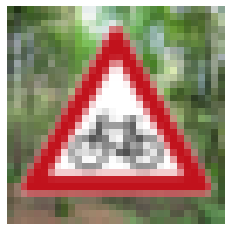

Adversarial class: No passing for vechiles over 3.5 metric tons


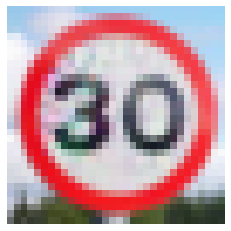

****************************************************


In [148]:
im = x_ben[i]
print("Original class: " + signnames[predict(model, im)])
plt.imshow(im)
plt.axis('off')
plt.show()

im = x_adv
print("Adversarial class: " + signnames[predict(model, im)])
plt.imshow(im)
plt.axis('off')
plt.show()
print('****************************************************')